In [208]:
import re
import random
import pandas as pd
import hashlib

In [209]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [210]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,10.083908,1.120434,2.079305,9
Email Auth and Security,186.948419,46.737105,70.573824,4
Azure VM + Developer,232.325594,6.833106,15.378527,34
"Jane Eyre, Bronte",313.919946,39.239993,57.816545,8
TSQL,535.422558,22.309273,30.772178,24
Azure AD Authentication,760.315925,63.359660,137.164482,12
RAG Project,810.242122,90.026902,242.077375,9
Logging in Python,866.980815,61.927201,104.599010,14
Azure Private DNS,1433.414182,75.442852,150.673406,19
Azure Functions + PP365,1940.285545,92.394550,217.548755,21


# Histogram

sum of ages: ~46994.73


<Axes: >

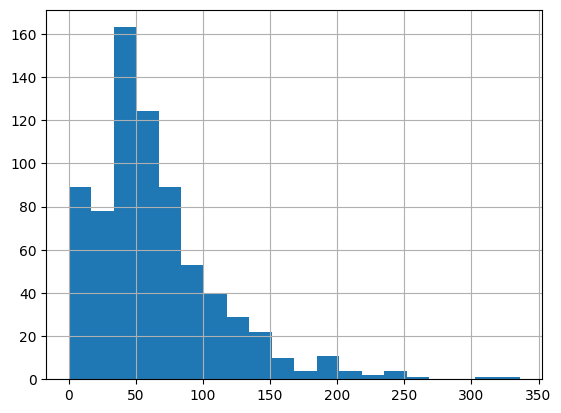

In [211]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~46994.73


<Axes: >

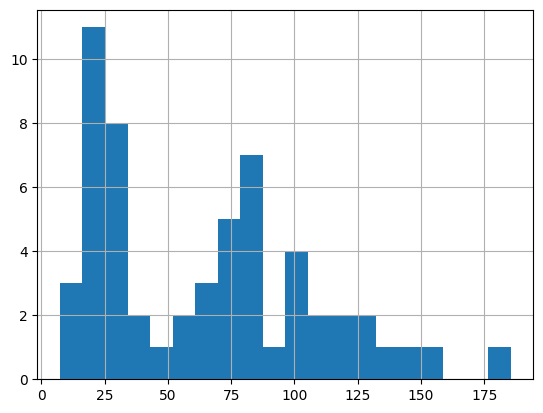

In [212]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [213]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [214]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [215]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [216]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [217]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [218]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [219]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [220]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 725
Total card age: 46994.73


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
16,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,-268.093421,75.394035,268.093421,-4146.671949,0.092004,0,0
17,PnP PowerShell,PowerShell Remoting\nA feature allowing comman...,9a85c3e15e615aee1582d54c4943687c,-187.703599,75.394035,268.093421,-4146.671949,0.092004,3,0
477,PnP PowerShell,Token Caching\nStores OAuth tokens locally to ...,858ddbb9a01a45de7b5f75cec44b2f6e,-136.644381,75.394035,268.093421,-4146.671949,0.092004,6,0
19,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-109.692140,75.394035,268.093421,-4146.671949,0.092004,9,0
20,PnP PowerShell,New-Object (Microsoft.PowerShell.Utility)\nCre...,985de2015a6f41fa0285e934d18ecf90,-86.461233,75.394035,268.093421,-4146.671949,0.092004,12,0
21,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,-74.108356,75.394035,268.093421,-4146.671949,0.092004,15,0
22,PnP PowerShell,Import-PnPProvisioningTemplate (PnP.PowerShell...,631be413fd92ed990499319481b60c4f,-69.240495,75.394035,268.093421,-4146.671949,0.092004,18,0
482,PnP PowerShell,Add-PnPField (PnP.PowerShell)\nAdds a new fiel...,63788258f43015c21266b6880c3934fc,-63.730003,75.394035,268.093421,-4146.671949,0.092004,21,0
24,PnP PowerShell,ConvertFrom-SecureString (Microsoft.PowerShell...,b0b4929ceace8c20afb149c725b37fc2,-60.495861,75.394035,268.093421,-4146.671949,0.092004,24,0
259,PnP PowerShell,OAuth 2.0 Authorization Code Flow\nAn interact...,5a398c5a70bd519c071d5ba565452168,-55.377092,75.394035,268.093421,-4146.671949,0.092004,27,0


## Age Mean

In [221]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [222]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [223]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [224]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [225]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
720,JavaScript Concepts,Front: What are tagged templates and how do yo...,c01058319c7e76b3d1c1a0e23a0ab7af,-0.083073,43.741729,239.117372,-3543.080042,0.036976,80,2
710,JavaScript Concepts,"In JavaScript, you can only return exactly one...",ff371a8725914a03ceed40564889f505,-0.214123,43.741729,239.117372,-3543.080042,0.036976,79,1
680,DAX,KEEPFILTERS protects nested security or busine...,0cf299bbeeebf5bad5e600ad270acdbe,-0.218939,1.120434,2.079305,-10.083908,0.209503,8,2
701,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,-0.229986,43.741729,239.117372,-3543.080042,0.036976,78,0
713,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-0.291888,43.741729,239.117372,-3543.080042,0.036976,77,2
724,JavaScript Concepts,Callback\nA function passed as an argument to ...,9b3cd917f72d441abfeee7a79c32a076,-0.303848,43.741729,239.117372,-3543.080042,0.036976,76,1
682,DAX,KEEPFILTERS vs. ALL/REMOVEFILTERS (and other m...,5d7a1a933dccd50da553422291e161c0,-0.309444,1.120434,2.079305,-10.083908,0.209503,7,1
676,DAX,"KEEPFILTERS is a modifier, not a standalone fu...",7a0281de21010d4d00b478be91e8278f,-0.328202,1.120434,2.079305,-10.083908,0.209503,6,0
704,JavaScript Concepts,If the addition operator + is used for primiti...,9cb500afa3eac8e680fbc3cd173ada6b,-0.352331,43.741729,239.117372,-3543.080042,0.036976,75,0
712,JavaScript Concepts,To create a deep copy of an object in JavaScri...,5aa92b62a155297018328adb830f62a1,-0.362094,43.741729,239.117372,-3543.080042,0.036976,74,2


In [226]:
existing_cards.head(10).sum()

head                   PnP PowerShellPnP PowerShellPnP PowerShellPnP ...
body                   Set-PnPList (PnP.PowerShell)\nModifies propert...
hash                   ec61ff7f95b8fe03595feae81fd537989a85c3e15e615a...
age                                                         -1111.546581
subject_mean_age                                              753.940354
subject_highest_age                                          2680.934213
subject_age_sum                                            -41466.719495
head_random_roll                                                 0.92004
count                                                                135
n_fold                                                                 0
dtype: object

In [227]:
existing_cards['age'].mean()

-64.82031997635005